In [1]:
from copy import deepcopy
import os
import pathlib
import sys

In [2]:
from mpl_toolkits.mplot3d.axes3d import Axes3D
from tqdm.notebook import tqdm
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import torch

In [3]:
sys.path.append(os.path.join(sys.path[0], '../..'))

from endure.data.io import Reader
from endure.lcm.model.builder import LearnedCostModelBuilder
from endure.lsm.solver import EndureLevelSolver
from endure.ltune.data.generator import LTuneGenerator
from endure.ltune.loss import LearnedCostModelLoss
from endure.ltune.model.builder import LTuneModelBuilder
import endure.lsm.cost_model as Cost

# Loading Model

In [58]:
path = '/data/models/ltune/level-05-10-write-bias-scaled'
config = Reader.read_config(os.path.join(path, 'endure.toml'))
# config = Reader.read_config('../../endure.toml')
cf = Cost.EndureLevelCost(config)

In [59]:
model = LTuneModelBuilder(config).build_model()
model_name = os.path.join(path, 'best.model')
# model_name = os.path.join(path, 'checkpoints/epoch_09.checkpoint')
model_data = torch.load(model_name)
model_params = model_data['model_state_dict'] if model_name.endswith('checkpoint') else model_data
status = model.load_state_dict(model_params)
model.eval()
# status

ClassicTuner(
  (sigmoid): Sigmoid()
  (bits): Sequential(
    (0): Linear(in_features=128, out_features=1, bias=True)
  )
  (size_ratio): Sequential(
    (0): Linear(in_features=128, out_features=1, bias=True)
  )
  (layers): Sequential(
    (0): BatchNorm1d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=9, out_features=128, bias=True)
    (2): Dropout(p=0.0, inplace=False)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): Dropout(p=0.0, inplace=False)
    (6): LeakyReLU(negative_slope=0.01)
    (7): Linear(in_features=128, out_features=128, bias=True)
    (8): Dropout(p=0.0, inplace=False)
    (9): LeakyReLU(negative_slope=0.01)
  )
)

In [60]:
model.layers[0].bias

Parameter containing:
tensor([-0.0305, -0.0507, -0.0302,  0.0707,  0.0293,  0.0359,  0.0715, -0.0074,
        -0.0222], requires_grad=True)

In [61]:
gen = LTuneGenerator(config)
x = torch.Tensor(gen.generate_row_csv())
x

tensor([1.8000e-01, 2.0900e-01, 3.5900e-01, 2.5200e-01, 6.4000e+01, 4.8602e-07,
        2.0480e+03, 8.1534e+00, 1.4894e+08])

In [62]:
def convert_model_out_to_design(output):
    output = output.flatten()
    h = output[0].item()
    if config["ltune"]["model"]["categorical"]:
        size_ratio = torch.argmax(output[1:])
    else:
        size_ratio = torch.ceil(output[1:]).item()
    return np.array([h, size_ratio + config['lsm']['size_ratio']['min']])

# Training Loss

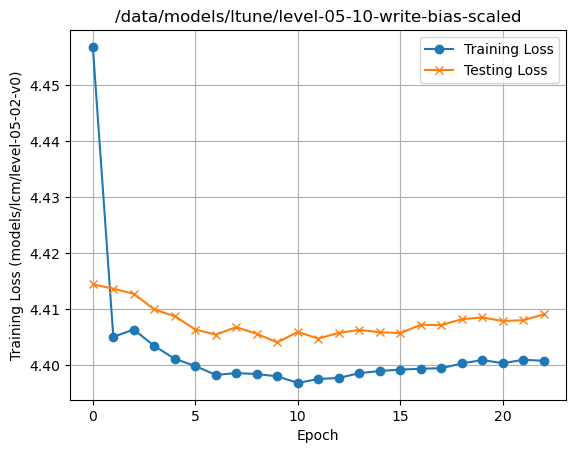

In [63]:
losses = pd.read_csv(os.path.join(path, 'losses.csv')).loc[0:40]
fig, ax = plt.subplots()
ax.plot(losses['epoch'], losses['train_loss'], '-o', label='Training Loss')
ax.plot(losses['epoch'], losses['test_loss'], '-x', label='Testing Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel(f'Training Loss ({config["job"]["LTuneTrain"]["loss_fn_path"]})')
ax.set_title(f'{path}')
ax.grid()
_ = ax.legend()

# Loading Learned Cost Model

In [64]:
loss = LearnedCostModelLoss(
    config,
    config["job"]["LTuneTrain"]["loss_fn_path"]
)
loss.eval()
loss_model = loss.model

In [65]:
def eval_lcm(design, system, wl):
    h, T = design
    B, s, E, H, N = system
    z0, z1, q, w = wl
    T = T - config['lsm']['size_ratio']['min']
    if T < 2:
        T = 2
    elif T > 48:
        T = 48
    inputs = torch.Tensor([z0, z1, q, w, B, s, E, H, N, h, T]).view(1, -1)
    with torch.no_grad():
        pred = loss_model(inputs)
        pred = pred.sum().item()
    return pred

In [66]:
def eval_acm(design, system, wl):
    h, T = design
    B, s, E, H, N = system
    z0, z1, q, w = wl
    if T < 2:
        T = 2
    elif T > 48:
        T = 48
    
    cfg = deepcopy(config)
    cfg["lsm"]["system"]["B"] = B
    cfg["lsm"]["system"]["s"] = s
    cfg["lsm"]["system"]["E"] = E
    cfg["lsm"]["system"]["H"] = H
    cfg["lsm"]["system"]["N"] = N
    cost = Cost.EndureLevelCost(cfg)

    return cost(h, T, z0, z1, q, w)

In [67]:
def get_system(cfg):
    B = cfg["lsm"]["system"]["B"]
    s = cfg["lsm"]["system"]["s"]
    E = cfg["lsm"]["system"]["E"]
    H = cfg["lsm"]["system"]["H"]
    N = cfg["lsm"]["system"]["N"]
    return (B, s, E, H, N)

# Evaluation

In [68]:
def eval_rand_workloads(num_wls=5000, system=None):
    cfg = deepcopy(config)
    if system is None:
        system = get_system(cfg)
    else:
        (B, s, E, H, N) = system
        cfg["lsm"]["system"]["B"] = B
        cfg["lsm"]["system"]["s"] = s
        cfg["lsm"]["system"]["E"] = E
        cfg["lsm"]["system"]["H"] = H
        cfg["lsm"]["system"]["N"] = N
    (B, s, E, H, N) = system
    solver = EndureLevelSolver(cfg)
    
    gen = LTuneGenerator(cfg)
    
    wls = []
    for _ in range(num_wls):
        wls.append(gen._sample_workload(4))
        
    table = [] 
    for wl in tqdm(wls):
        # (B, s, E, H, N) = system = gen._sample_system()
        # cfg["lsm"]["system"]["B"] = B
        # cfg["lsm"]["system"]["s"] = s
        # cfg["lsm"]["system"]["E"] = E
        # cfg["lsm"]["system"]["H"] = H
        # cfg["lsm"]["system"]["N"] = N
        solver = EndureLevelSolver(cfg)
        
        wl = np.array(wl)
        z0, z1, q, w = wl
        
        # eval normal
        sol = solver.find_nominal_design(z0, z1, q, w)
        # print(sol)
        stune_h, stune_T = sol.x
        stune_T = np.ceil(stune_T)
        stune_h = np.around(stune_h, 3)
        stune_loss = eval_lcm([stune_h, stune_T], system, wl)
        stune_cost = eval_acm([stune_h, stune_T], system, wl)
        # stune_level = cf.cf.L(stune_h, stune_T, True)
        
        # eval learned
        x = torch.Tensor((z0, z1, q, w, B, s, E, H, N)).view(1, -1)
        out = model(x, temp=1e-9, hard=True)
        ltune_h, ltune_T = convert_model_out_to_design(out)
        ltune_loss = eval_lcm((ltune_h, np.ceil(ltune_T)), system, wl)
        ltune_cost = eval_acm((ltune_h, np.ceil(ltune_T)), system, wl)
        # ltune_level = cf.cf.L(ltune_h, ltune_T, True)
        
        row = {
            'z0': z0,
            'z1': z1,
            'q': q,
            'w': w,
            'B': B,
            's': s,
            'E': E,
            'H': H,
            'N': N,
            'stune_h': stune_h,
            'stune_T': stune_T,
            'stune_cost': stune_cost,
            'stune_loss': stune_loss,
            # 'stune_level': stune_level,
            'ltune_h': ltune_h,
            'ltune_T': ltune_T,
            'ltune_cost': ltune_cost,
            'ltune_loss': ltune_loss,
            # 'ltune_level': ltune_level,
        }
        table.append(row)
    
    return pd.DataFrame(table)

In [69]:
np.random.seed(0)
df = eval_rand_workloads(num_wls=2000)
df['delta_cost'] = (df['stune_cost'] - df['ltune_cost']) / df['stune_cost']
df['delta_loss'] = (df['stune_loss'] - df['ltune_loss']) / df['stune_loss']
df['stune_diff'] = (df['stune_cost'] - df['stune_loss']) / df['stune_cost']
df['ltune_diff'] = (df['ltune_cost'] - df['ltune_loss']) / df['ltune_cost']

  0%|          | 0/2000 [00:00<?, ?it/s]

In [70]:
cols = ['z0', 'z1', 'q', 'w',
        'stune_h', 'stune_T',
        'ltune_h', 'ltune_T',
        'stune_cost', 'ltune_cost',
        'stune_loss', 'ltune_loss',
        'delta_cost', 'delta_loss',
        'stune_diff', 'ltune_diff']
df.sort_values(by='delta_cost', ascending=True).head(20)[cols]

,z0,z1,q,w,stune_h,stune_T,ltune_h,ltune_T,stune_cost,ltune_cost,stune_loss,ltune_loss,delta_cost,delta_loss,stune_diff,ltune_diff
111,0.697,0.080,0.002,0.221,6.386,3.0,5.514318,40.0,1.396404,4.689346,1.478940,4.688990,-2.358158,-2.170507,-0.059106,0.000076
1127,0.714,0.097,0.001,0.188,6.642,3.0,5.700077,40.0,1.209042,4.025496,1.306088,4.056504,-2.329492,-2.105843,-0.080267,-0.007703
526,0.628,0.141,0.001,0.230,6.248,3.0,4.814731,39.0,1.465898,4.747254,1.568716,4.788180,-2.238461,-2.052292,-0.070140,-0.008621
1936,0.476,0.057,0.005,0.462,4.831,3.0,3.035223,36.0,2.664639,8.522791,2.766874,8.615510,-2.198478,-2.113806,-0.038367,-0.010879
1295,0.450,0.162,0.001,0.387,5.121,3.0,2.773851,36.0,2.264610,7.162165,2.417578,7.251232,-2.162649,-1.999379,-0.067547,-0.012436
1802,0.450,0.174,0.003,0.373,5.160,3.0,2.789863,37.0,2.269848,7.113125,2.370430,7.159491,-2.133746,-2.020335,-0.044312,-0.006518
1119,0.269,0.036,0.001,0.694,3.388,3.0,0.827231,32.0,3.583896,11.158906,3.778872,11.222303,-2.113625,-1.969750,-0.054403,-0.005681
496,0.354,0.020,0.004,0.622,3.934,3.0,1.655393,33.0,3.348187,10.424115,3.478876,10.429783,-2.113361,-1.998032,-0.039033,-0.000544
1495,0.523,0.095,0.007,0.375,5.260,3.0,3.608578,37.0,2.339554,7.264204,2.435790,7.327674,-2.104952,-2.008336,-0.041134,-0.008737
226,0.110,0.295,0.000,0.595,2.984,3.0,0.052996,33.0,3.277917,9.854667,3.508333,9.912977,-2.006381,-1.825552,-0.070294,-0.005917


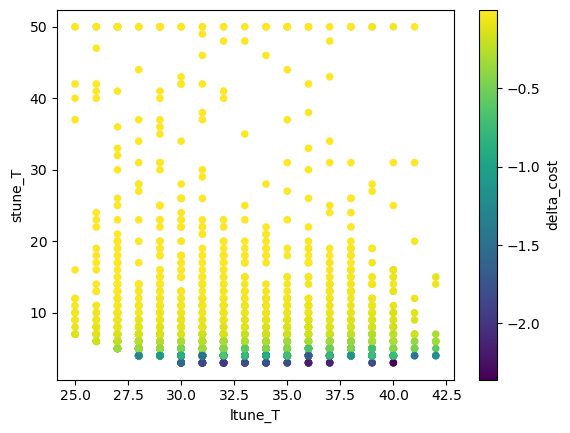

In [71]:
# fig, ax = plt.subplots()
ax = df.plot.scatter(x='ltune_T', y='stune_T', c='delta_cost', cmap='viridis')

In [72]:
df['ltune_T'].unique()

array([36., 34., 39., 33., 31., 26., 40., 27., 35., 32., 29., 38., 28.,
       37., 41., 30., 42., 25.])

## Analytical Cost Model

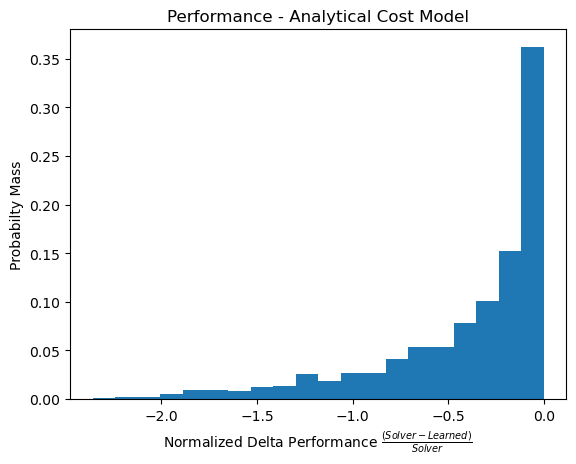

In [73]:
fig, ax = plt.subplots()
data = df['delta_cost']
ax.hist(data, bins=20, weights=np.ones_like(data)/len(data), alpha=1, density=False, label='ACM', color='tab:blue')
ax.set_ylabel('Probabilty Mass')
ax.set_xlabel('Normalized Delta Performance $\\frac{(Solver - Learned)}{Solver}$')
ax.set_title('Performance - Analytical Cost Model')
# ax.legend()
plt.show()

## Learned Cost Model

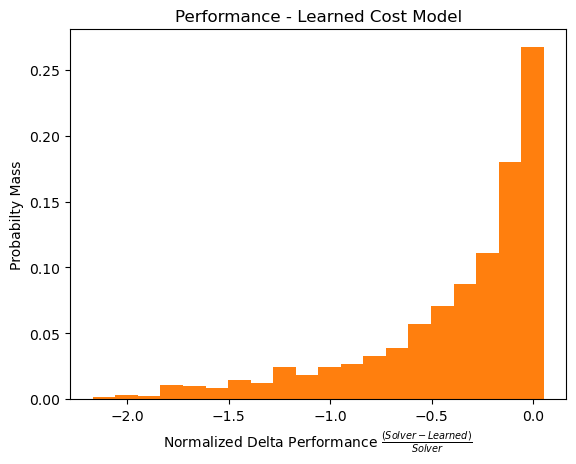

In [74]:
fig, ax = plt.subplots()
data = df['delta_loss']
ax.hist(data, weights=np.ones_like(data)/len(data), bins=20, density=False, color='tab:orange')
ax.set_ylabel('Probabilty Mass')
ax.set_xlabel('Normalized Delta Performance $\\frac{(Solver - Learned)}{Solver}$')
ax.set_title('Performance - Learned Cost Model')
plt.show()

## Difference in ACM and LCM

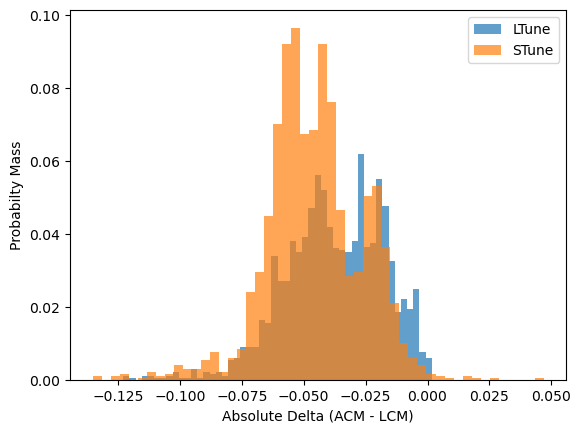

In [75]:
fig, ax = plt.subplots()
ldata = df['ltune_diff']
sdata = df['stune_diff']
ax.hist(ldata, weights=np.ones_like(ldata)/len(ldata), bins=50, alpha=0.7, label='LTune', color='tab:blue')
ax.hist(sdata, weights=np.ones_like(sdata)/len(sdata), bins=50, alpha=0.7, label='STune', color='tab:orange')
ax.set_ylabel('Probabilty Mass')
ax.set_xlabel('Absolute Delta (ACM - LCM)')
ax.legend()
plt.show()

In [76]:
df['ltune_mbuff'] = ((df['H'] - df['ltune_h']) * df['N']) / (1 * 1024 * 1024 * 1024 * 8)

## Workload Correlations

In [77]:
def plot_workload_trend(trend='stune_T'):
    fig = plt.figure()
    ax = Axes3D(fig, auto_add_to_figure=False, computed_zorder=False)
    fig.add_axes(ax)
    ax.set_xlim3d(0, 1), ax.set_ylim3d(1, 0), ax.set_zlim3d(0, 1)
    ax.set_xticks([0, 0.5, 1]), ax.set_yticks([0, 0.5, 1]), ax.set_zticks([0, 0.5, 1])
    ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax.zaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    edge = ax.plot([0, 1, 0, 0], [0, 0, 1, 0], [1, 0, 0, 1], color='black', zorder=3)

    ax.set_xlabel('Point-Reads\n($z_0$ + $z_1$)', labelpad=15)
    ax.set_ylabel('Range-Reads (q)', labelpad=10)
    ax.set_zlabel('Writes (w)', labelpad=10)

    sc = ax.scatter(df['z0'] + df['z1'], df['q'], df['w'], c=df[trend], cmap='viridis')
    cbar = plt.colorbar(sc)
    cbar.set_label(trend)
    
    return fig, ax, sc, cbar

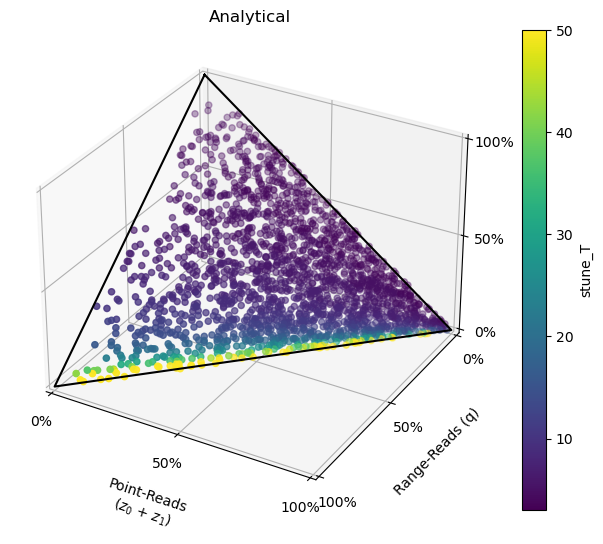

In [78]:
fig, ax, sc, cbar = plot_workload_trend(trend='stune_T')
ax.set_title('Analytical')
plt.show()

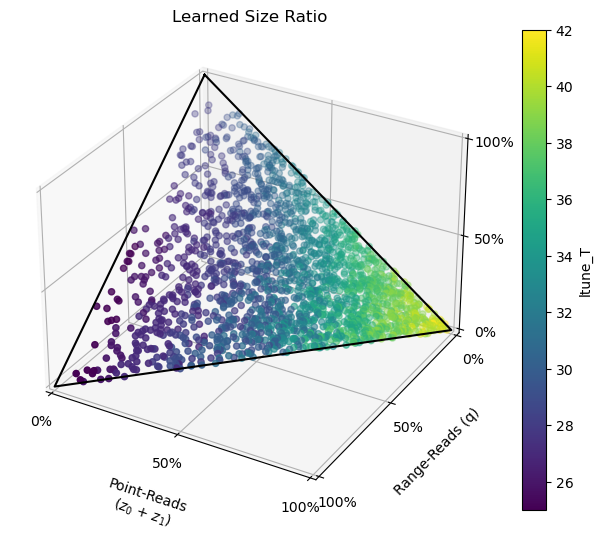

In [79]:
fig, ax, sc, cbar = plot_workload_trend(trend='ltune_T')
ax.set_title('Learned Size Ratio')
plt.show()

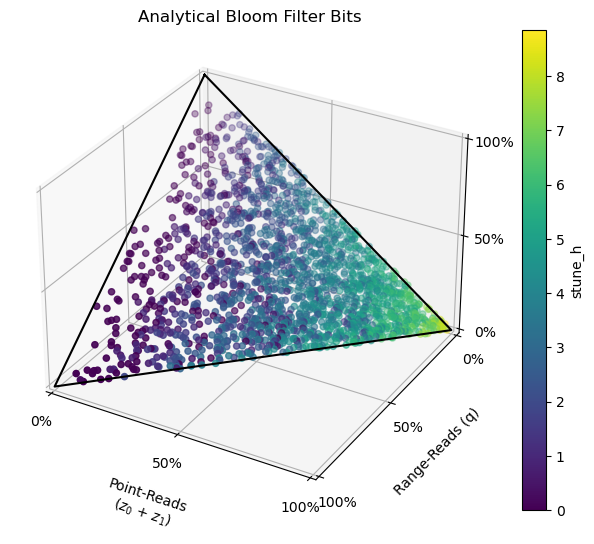

In [80]:
fig, ax, sc, cbar = plot_workload_trend(trend='stune_h')
ax.set_title('Analytical Bloom Filter Bits')
plt.show()

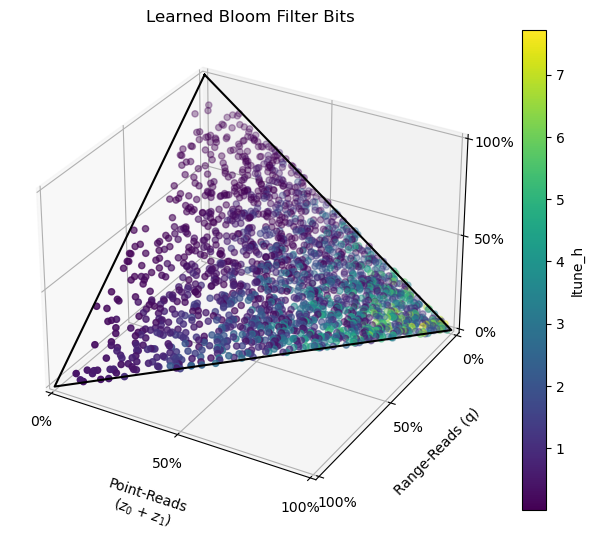

In [81]:
fig, ax, sc, cbar = plot_workload_trend(trend='ltune_h')
ax.set_title('Learned Bloom Filter Bits')
plt.show()

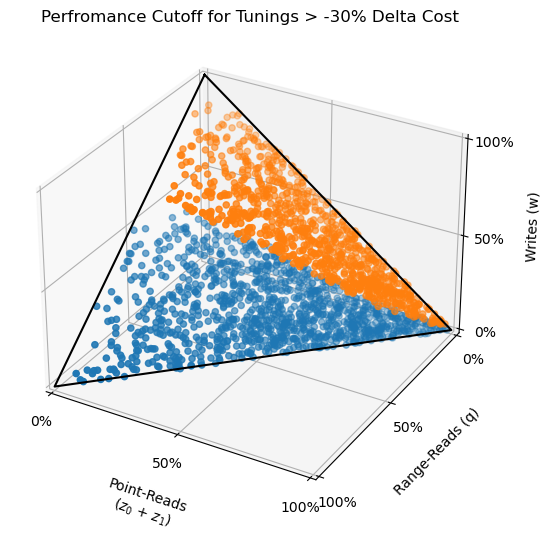

In [82]:
fig = plt.figure()
ax = Axes3D(fig, auto_add_to_figure=False, computed_zorder=False)
fig.add_axes(ax)
ax.set_xlim3d(0, 1), ax.set_ylim3d(1, 0), ax.set_zlim3d(0, 1)
ax.set_xticks([0, 0.5, 1]), ax.set_yticks([0, 0.5, 1]), ax.set_zticks([0, 0.5, 1])
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.zaxis.set_major_formatter(mtick.PercentFormatter(1.0))
edge = ax.plot([0, 1, 0, 0], [0, 0, 1, 0], [1, 0, 0, 1], color='black', zorder=3)

ax.set_xlabel('Point-Reads\n($z_0$ + $z_1$)', labelpad=15)
ax.set_ylabel('Range-Reads (q)', labelpad=10)
ax.set_zlabel('Writes (w)', labelpad=10)

cutoff = (-0.3)
groupa = df[df['delta_loss'] > cutoff]
groupb = df[df['delta_loss'] < cutoff]
ax.scatter(groupa['z0'] + groupa['z1'], groupa['q'], groupa['w'], label='Decent')
ax.scatter(groupb['z0'] + groupb['z1'], groupb['q'], groupb['w'], label='Poor')
ax.set_title(f'Perfromance Cutoff for Tunings > {cutoff:.0%} Delta Cost')
plt.show()

In [83]:
def bias_sample(dimensions=4):
    max_non_writes = np.random.rand() * 0.5
    workload = list(np.random.rand(dimensions - 1) * max_non_writes) + [0, 1]
    workload.sort()
    workload = [b - a for a, b in zip(workload, workload[1:])]
    
    return workload

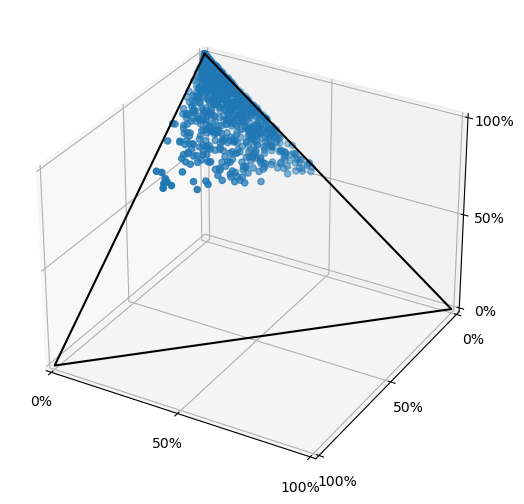

In [84]:
workloads = [bias_sample() for _ in range(1000)]
data = pd.DataFrame(workloads, columns=['z0', 'z1', 'q', 'w'])

fig = plt.figure()
ax = Axes3D(fig, auto_add_to_figure=False, computed_zorder=False)
fig.add_axes(ax)
ax.set_xlim3d(0, 1), ax.set_ylim3d(1, 0), ax.set_zlim3d(0, 1)
ax.set_xticks([0, 0.5, 1]), ax.set_yticks([0, 0.5, 1]), ax.set_zticks([0, 0.5, 1])
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.zaxis.set_major_formatter(mtick.PercentFormatter(1.0))
edge = ax.plot([0, 1, 0, 0], [0, 0, 1, 0], [1, 0, 0, 1], color='black', zorder=3)

ax.scatter(data['z0'] + data['z1'], data['q'], data['w'])
plt.show()